In [5]:
# Install required packages (run once in Colab)
!pip install -q yfinance pmdarima statsmodels prophet tensorflow scikit-learn matplotlib seaborn plotly
# For some Colab environments you may need: !pip install -q pystan==2.19.1.1 prophet


In [1]:
# Standard imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [2]:
# Parameters - change ticker or dates as needed
TICKER = "AAPL"                # Example: AAPL, BTC-USD, ^NSEI (NIFTY50)
START_DATE = "2015-01-01"
END_DATE = None
INTERVAL = "1d"

# Download
end = END_DATE if END_DATE else datetime.today().strftime("%Y-%m-%d")
df = yf.download(TICKER, start=START_DATE, end=end, interval=INTERVAL, progress=False)

# Handle missing or empty data
if df.empty:
    raise ValueError(f"No data found for {TICKER}. Try another ticker.")

# THESE columns may or may not exist, depending on ticker
possible_cols = ['Open','High','Low','Close','Adj Close','Volume']

# Select only columns that exist
df = df[[col for col in possible_cols if col in df.columns]]

# Rename Adj Close → Adj_Close (optional consistency)
if 'Adj Close' in df.columns:
    df.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

df.index.name = 'Date'
df = df.sort_index()

print(f"Downloaded {len(df)} rows with columns: {list(df.columns)}")
df.head()


Downloaded 2744 rows with columns: [('Open', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Close', 'AAPL'), ('Volume', 'AAPL')]


Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.694235,24.705320,23.798600,24.237551,212818400
2015-01-05,24.006992,24.086801,23.368521,23.554741,257142000
2015-01-06,23.619031,23.816336,23.195599,23.556957,263188400
2015-01-07,23.765348,23.987040,23.654503,23.887280,160423600
2015-01-08,24.215378,24.862717,24.097880,24.805077,237458000


,,count,mean,std,min,25%,50%,75%,max
Price,Ticker,,,,,,,,
Open,AAPL,2744.0,1.048621e+02,7.294735e+01,2.052653e+01,3.657691e+01,8.495616e+01,1.676644e+02,2.772600e+02
High,AAPL,2744.0,1.060082e+02,7.374339e+01,2.090741e+01,3.686335e+01,8.568368e+01,1.692766e+02,2.803800e+02
Low,AAPL,2744.0,1.038112e+02,7.224576e+01,2.040566e+01,3.622339e+01,8.364904e+01,1.662494e+02,2.766300e+02
Close,AAPL,2744.0,1.049618e+02,7.303561e+01,2.060408e+01,3.651892e+01,8.503619e+01,1.676550e+02,2.788500e+02
Volume,AAPL,2744.0,1.119556e+08,6.799351e+07,2.013560e+07,6.545978e+07,9.485540e+07,1.375286e+08,6.488252e+08


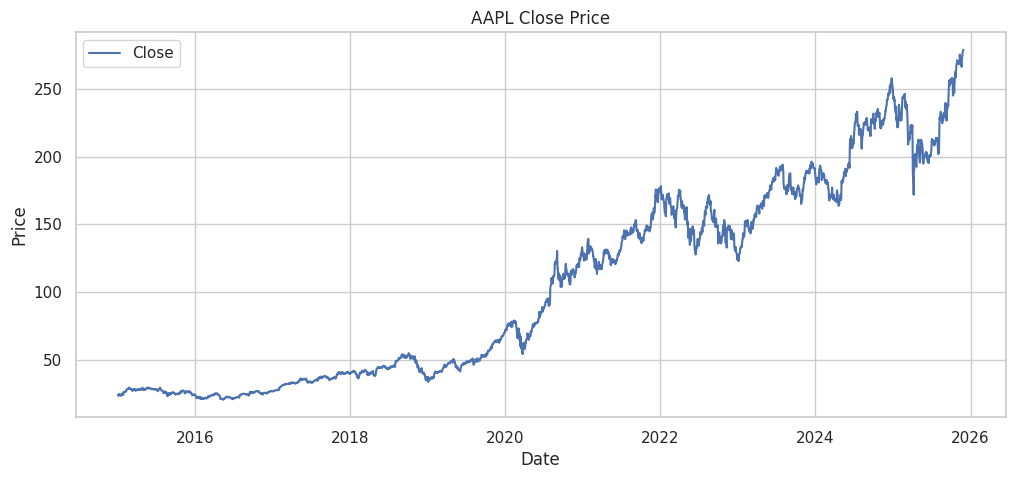

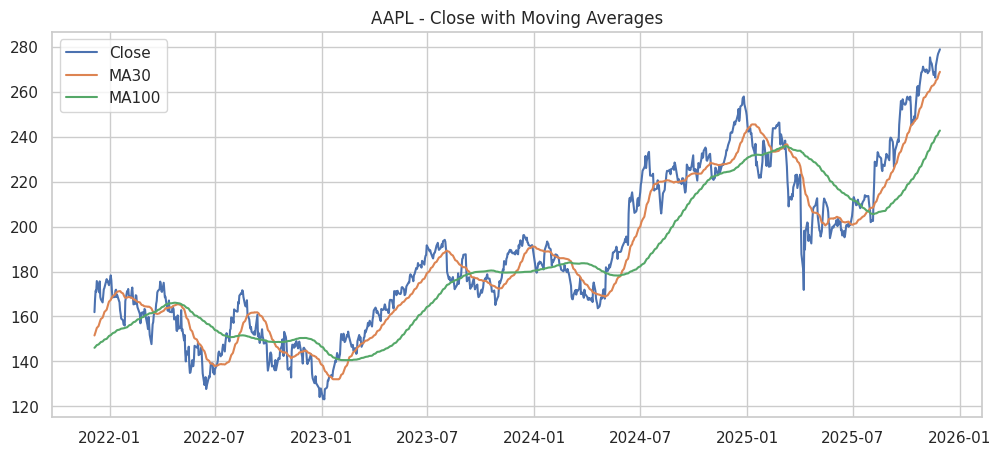

In [3]:
# Quick stats
display(df.describe().T)

# Plot closing price
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'], label='Close')
plt.title(f"{TICKER} Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Moving averages
df['MA30'] = df['Close'].rolling(window=30).mean()
df['MA100'] = df['Close'].rolling(window=100).mean()

plt.figure(figsize=(12,5))
plt.plot(df['Close'][-1000:], label='Close')
plt.plot(df['MA30'][-1000:], label='MA30')
plt.plot(df['MA100'][-1000:], label='MA100')
plt.title(f"{TICKER} - Close with Moving Averages")
plt.legend()
plt.show()


In [10]:
# Train/Test split & utility functions

from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return (np.abs((y_true - y_pred) / y_true)[mask].mean()) * 100

def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MAPE": mape(y_true, y_pred)
    }

# SAFE series assignment
# Correctly access the 'Close' column as a pandas Series from the MultiIndex DataFrame
series = df[('Close', TICKER)] # Use TICKER variable for dynamic access
series.name = "Close" # Assign a simple name for easier handling

TEST_SIZE = 0.2
split_idx = int(len(series) * (1 - TEST_SIZE))

train = series.iloc[:split_idx]
test  = series.iloc[split_idx:]


print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 2195, Test size: 549


Augmented Dickey-Fuller Test: AAPL Close - Train


,0
ADF Statistic,-0.044722
p-value,0.954674
#Lags Used,18.000000
Number of Observations Used,2176.000000
Critical Value (1%),-3.433359
Critical Value (5%),-2.862869
Critical Value (10%),-2.567478


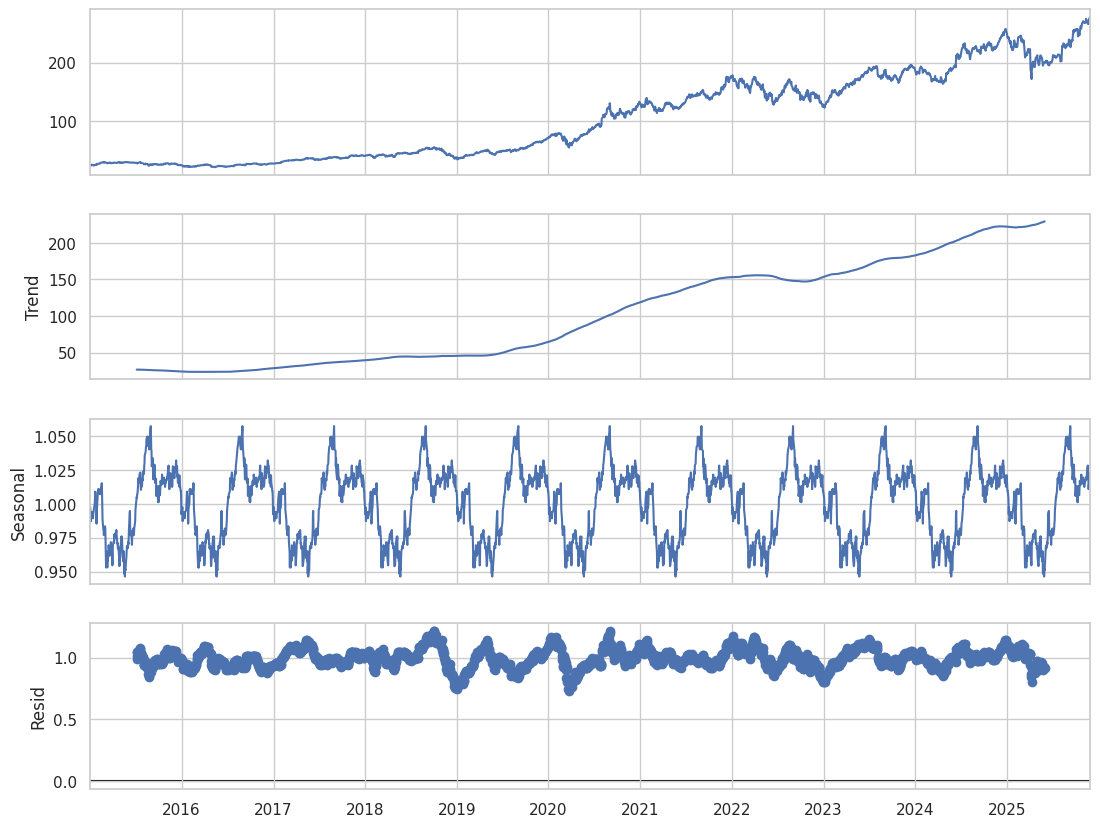

In [5]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# ADF test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Statistic','p-value','#Lags Used','Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    display(out)

adf_test(train, title=f'{TICKER} Close - Train')

# Decompose (multiplicative or additive depending on series)
period = 252  # approx trading days per year
decomp = seasonal_decompose(series.dropna(), model='multiplicative', period=period)
fig = decomp.plot()
fig.set_size_inches(12,9)
plt.show()


Fitting auto_arima (this may take a moment)...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8763.200, Time=3.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8762.547, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8761.283, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8761.073, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8763.686, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8760.797, Time=1.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8762.435, Time=1.83 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8762.462, Time=1.97 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8761.028, Time=0.91 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8761.302, Time=0.59 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8762.563, Time=0.59 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 11.280 seconds
ARIMA metrics: {'MAE': 23.528075178161632, 'RMSE': np.float64(29.76758417512519), 'MAPE': np.float64(10.31

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


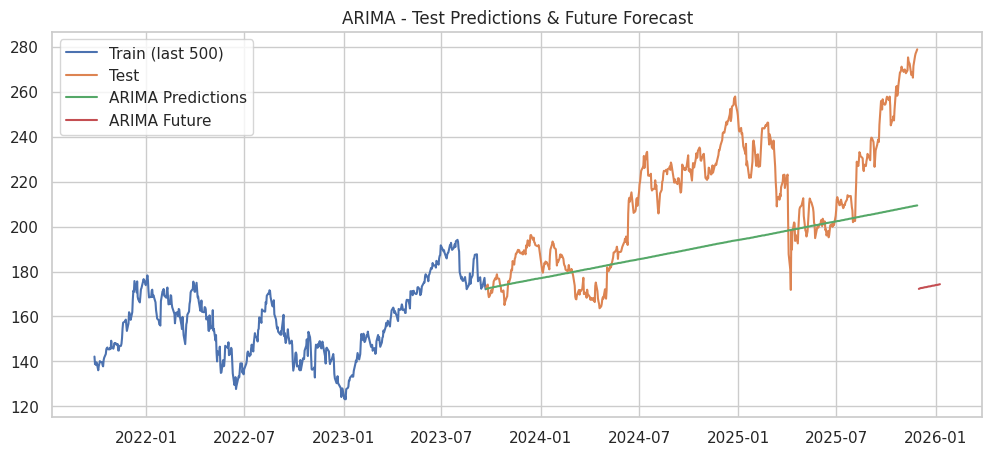

In [6]:
import numpy as np
import pmdarima as pm

# Fit auto_arima on train
print("Fitting auto_arima (this may take a moment)...")
arima_model = pm.auto_arima(
    train,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Forecast on test horizon
n_test = len(test)
pred_arima = arima_model.predict(n_periods=n_test)

# 🔥 FIX: Ensure predictions are 1-D
pred_arima = np.array(pred_arima).reshape(-1)

# Evaluate ARIMA
arima_metrics = evaluate(test.values.reshape(-1), pred_arima)
print("ARIMA metrics:", arima_metrics)

# Forecast future days (example 30 business days)
FUTURE_DAYS = 30
future_arima = arima_model.predict(n_periods=FUTURE_DAYS)

# 🔥 FIX: Flatten future forecast too
future_arima = np.array(future_arima).reshape(-1)

# Plot test results and future
plt.figure(figsize=(12,5))
plt.plot(train.index[-500:], train[-500:], label='Train (last 500)')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, pred_arima, label='ARIMA Predictions')

future_index = pd.date_range(
    start=df.index[-1] + pd.Timedelta(days=1),
    periods=FUTURE_DAYS,
    freq='B'
)

plt.plot(future_index, future_arima, label='ARIMA Future')
plt.legend()
plt.title("ARIMA - Test Predictions & Future Forecast")
plt.show()


Fitting Auto-Seasonal SARIMA (fast)...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=8764.060, Time=3.16 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=8762.547, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=8760.122, Time=1.18 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=8759.771, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=8763.686, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=8761.073, Time=0.61 sec
 ARIMA(0,1,1)(1,0,1)[5] intercept   : AIC=8761.425, Time=1.49 sec
 ARIMA(0,1,1)(0,0,2)[5] intercept   : AIC=8760.805, Time=1.36 sec
 ARIMA(0,1,1)(1,0,0)[5] intercept   : AIC=8759.920, Time=0.52 sec
 ARIMA(0,1,1)(1,0,2)[5] intercept   : AIC=8756.284, Time=5.83 sec
 ARIMA(0,1,1)(2,0,2)[5] intercept   : AIC=8761.984, Time=5.26 sec
 ARIMA(0,1,1)(2,0,1)[5] intercept   : AIC=8756.263, Time=4.78 sec
 ARIMA(0,1,1)(2,0,0)[5] intercept   : AIC=8760.562, Time=1.04 sec
 ARIMA(0,1,0)(2,0,1)[5] intercept   : AIC=8757.513, Time=3.5

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


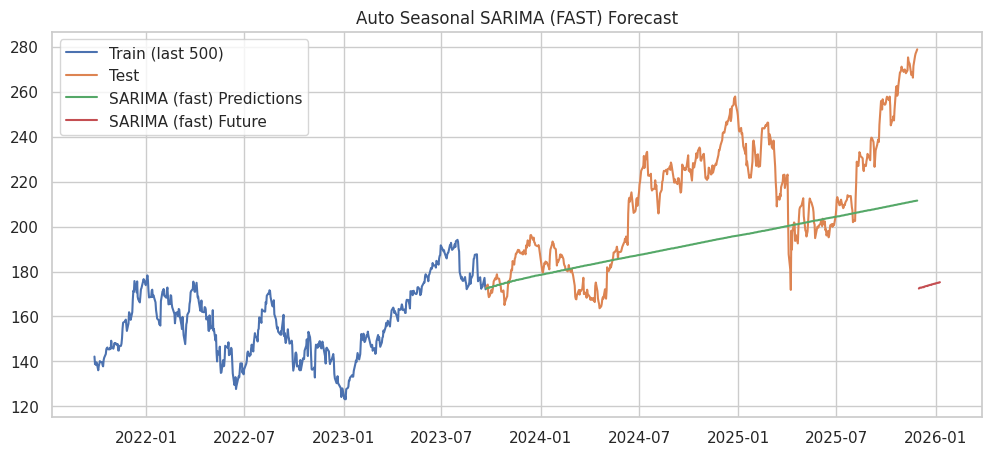

In [7]:
import pmdarima as pm
import numpy as np

print("Fitting Auto-Seasonal SARIMA (fast)...")

# Auto Seasonal SARIMA (FAST)
sarima_fast = pm.auto_arima(
    train,
    seasonal=True,
    m=5,                  # weekly seasonality for stocks (VERY FAST)
    trace=True,
    stepwise=True,
    error_action='ignore',
    suppress_warnings=True,
    max_p=3, max_q=3,
    max_P=2, max_Q=2
)

print("\nBest SARIMA model:", sarima_fast.summary())

# Forecast on test size
n_test = len(test)
pred_sarima = sarima_fast.predict(n_periods=n_test)
pred_sarima = np.array(pred_sarima).reshape(-1)   # shape-safe

# Evaluate
sarima_metrics = evaluate(test.values.reshape(-1), pred_sarima)
print("\nFAST SARIMA metrics:", sarima_metrics)

# Future forecast (e.g., next 30 business days)
FUTURE_DAYS = 30
future_sarima = sarima_fast.predict(n_periods=FUTURE_DAYS)
future_sarima = np.array(future_sarima).reshape(-1)

# Business-day index for future
future_index = pd.date_range(
    start=df.index[-1] + pd.Timedelta(days=1),
    periods=FUTURE_DAYS,
    freq='B'
)

# Plot Test Results + Future Prediction
plt.figure(figsize=(12,5))
plt.plot(train[-500:], label="Train (last 500)")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, pred_sarima, label="SARIMA (fast) Predictions")
plt.plot(future_index, future_sarima, label="SARIMA (fast) Future")
plt.title("Auto Seasonal SARIMA (FAST) Forecast")
plt.legend()
plt.show()


Prophet metrics: {'MAE': 14.078510688089978, 'RMSE': np.float64(16.554171465070834), 'MAPE': np.float64(6.680341914369292)}


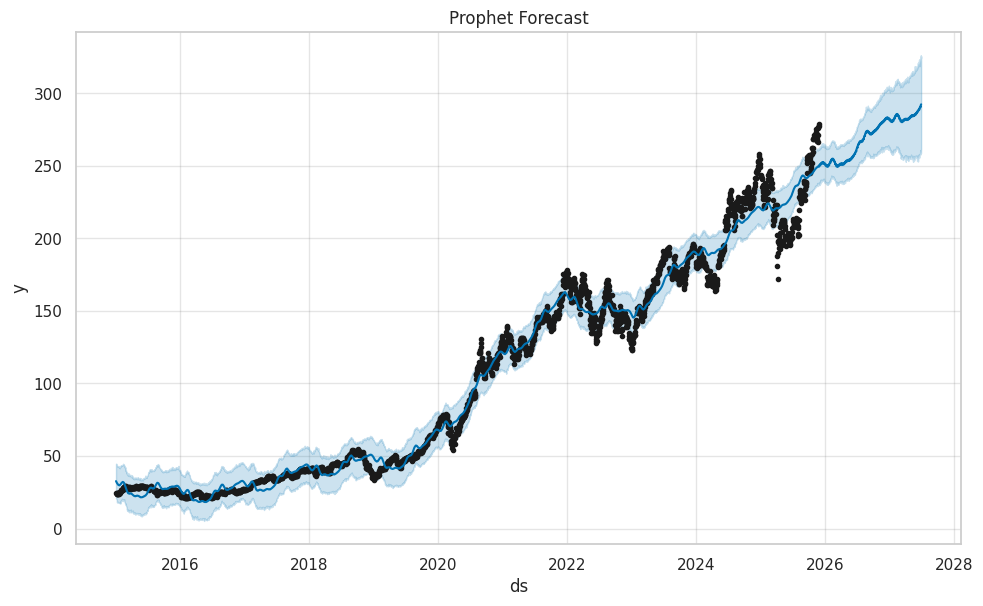

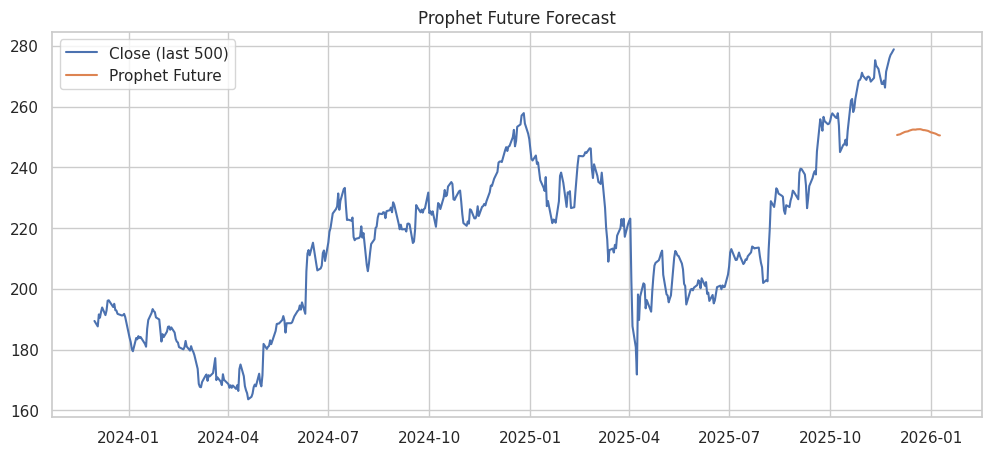

In [12]:
from prophet import Prophet
import numpy as np

# Prepare Prophet dataframe
prophet_df = series.reset_index()
prophet_df.columns = ["ds", "y"]    # Prophet requires ds (date) and y (value)

# Fit model
m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)
m.fit(prophet_df)

# Create future dates (Prophet forecasts daily)
periods = len(test) + FUTURE_DAYS
future = m.make_future_dataframe(periods=periods, freq='D')

# Forecast
forecast = m.predict(future)

# Extract only the test horizon (Prophet outputs daily data including weekends)
# Align Prophet's yhat to business-day test index
forecast_indexed = forecast.set_index("ds")["yhat"]
pred_prophet_test = forecast_indexed.reindex(test.index).values

# Fix shape
pred_prophet_test = np.array(pred_prophet_test).reshape(-1)

# Evaluate
prophet_metrics = evaluate(test.values.reshape(-1), pred_prophet_test)
print("Prophet metrics:", prophet_metrics)

# Plot full Prophet components
fig = m.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

# Create business-day future forecast for next FUTURE_DAYS
future_index = pd.date_range(
    start=df.index[-1] + pd.Timedelta(days=1),
    periods=FUTURE_DAYS,
    freq='B'
)

future_prophet = forecast_indexed.reindex(future_index).values
future_prophet = np.array(future_prophet).reshape(-1)

# Plot Prophet future
plt.figure(figsize=(12,5))
plt.plot(series[-500:], label="Close (last 500)")
plt.plot(future_index, future_prophet, label="Prophet Future")
plt.legend()
plt.title("Prophet Future Forecast")
plt.show()


LSTM shapes: (2175, 20, 1) (2175, 1) (549, 20, 1) (549, 1)
Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0244 - val_loss: 5.3271e-04
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 5.1567e-04
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 5.0048e-04
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.5841e-04 - val_loss: 3.4997e-04
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.4034e-04 - val_loss: 5.4078e-04
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.7603e-04 - val_loss: 0.0017
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.6176e-04 - val_loss: 0.0015
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.7057e-04 - val_loss: 5.3226e-04
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.9605e-04 - val_loss: 0.0013
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.4120e-04 - val_loss: 4.2799e-04
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

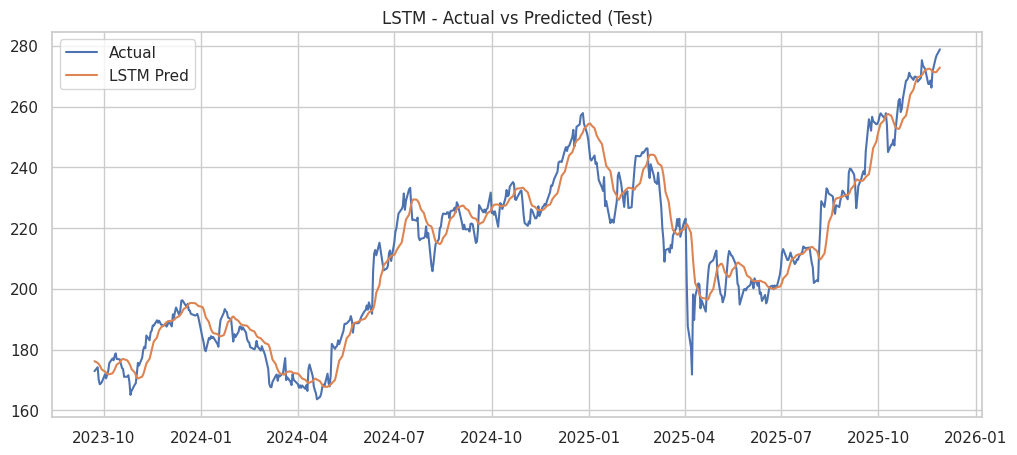

In [13]:
# LSTM setup
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Use entire series for scaling (train+test)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(series.values.reshape(-1,1))

# Create sequences
def create_sequences(values, window=20):
    X, y = [], []
    for i in range(len(values) - window):
        X.append(values[i:i+window])
        y.append(values[i+window])
    return np.array(X), np.array(y)

WINDOW = 20
X_all, y_all = create_sequences(scaled, WINDOW)

# Align to earlier train/test split
# When we created sequences, the first label corresponds to index WINDOW
# So compute new split index for sequences
seq_split = split_idx - WINDOW
X_train = X_all[:seq_split]
y_train = y_all[:seq_split]
X_test = X_all[seq_split:]
y_test = y_all[seq_split:]

# reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("LSTM shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Build model
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(WINDOW,1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train (tune epochs as needed)
EPOCHS = 30
BATCH = 32
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_split=0.1, callbacks=[es], verbose=1)

# Predict on X_test and inverse scale
pred_lstm_scaled = model.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_lstm_scaled).flatten()
y_test_rescaled = scaler.inverse_transform(y_test).flatten()

lstm_metrics = evaluate(y_test_rescaled, pred_lstm)
print("LSTM metrics:", lstm_metrics)

# Plot last portion
plt.figure(figsize=(12,5))
plt.plot(series.index[-len(y_test_rescaled):], y_test_rescaled, label='Actual')
plt.plot(series.index[-len(pred_lstm):], pred_lstm, label='LSTM Pred')
plt.legend()
plt.title("LSTM - Actual vs Predicted (Test)")
plt.show()


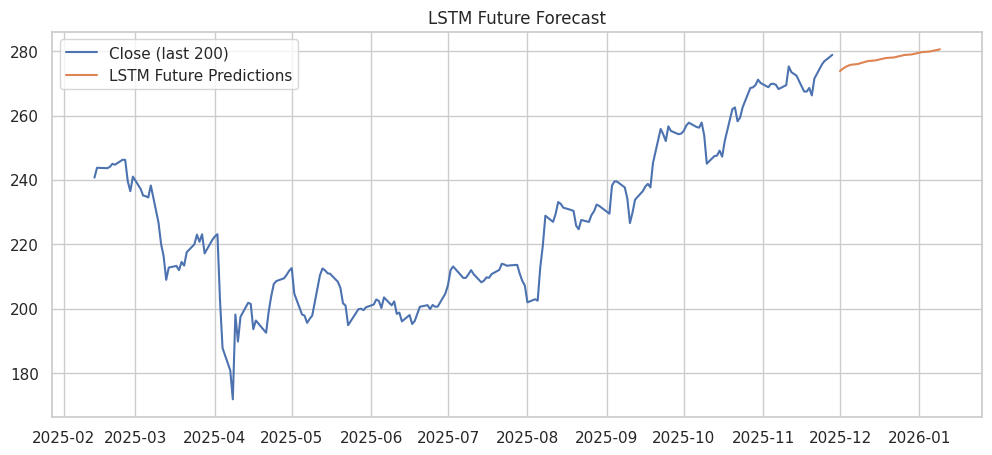

In [14]:
# Create iterative forecast starting from last window of available scaled data
def forecast_lstm_iterative(model, scaler, last_window_scaled, steps=30):
    last_window = last_window_scaled.copy().reshape(-1).tolist()
    preds = []
    for _ in range(steps):
        x = np.array(last_window[-WINDOW:]).reshape((1, WINDOW, 1))
        yhat = model.predict(x, verbose=0)[0,0]
        preds.append(yhat)
        last_window.append(yhat)
    preds = np.array(preds).reshape(-1,1)
    return scaler.inverse_transform(preds).flatten()

# last window from scaled data (most recent WINDOW values)
last_win_scaled = scaled[-WINDOW:].reshape(-1,1)
future_lstm_preds = forecast_lstm_iterative(model, scaler, last_win_scaled, steps=FUTURE_DAYS)
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=FUTURE_DAYS, freq='B')

plt.figure(figsize=(12,5))
plt.plot(series[-200:], label='Close (last 200)')
plt.plot(future_index, future_lstm_preds, label='LSTM Future Predictions')
plt.legend()
plt.title("LSTM Future Forecast")
plt.show()


,MAE,RMSE,MAPE
Model,,,
ARIMA,23.528075,29.767584,10.319928
SARIMA,22.393485,28.401380,9.838725
Prophet,14.078511,16.554171,6.680342
LSTM,5.328542,7.111264,2.537267


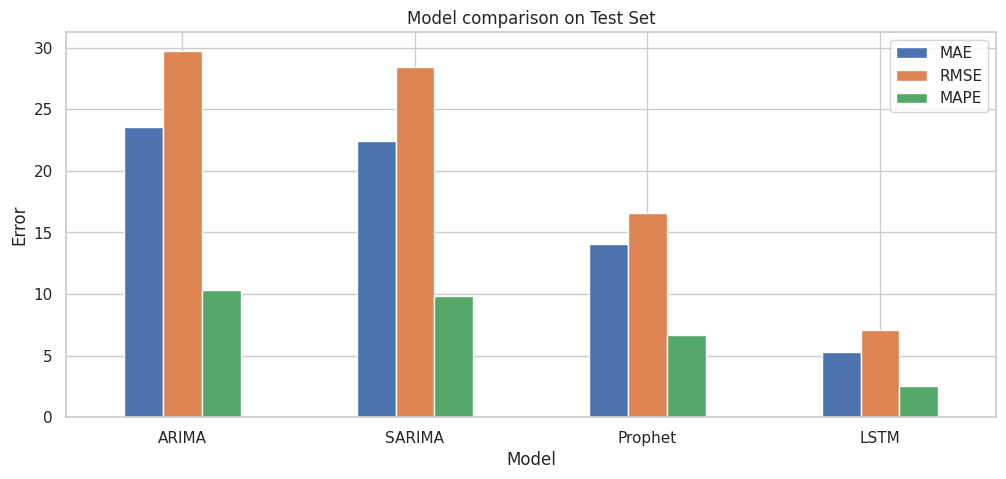

In [15]:
# Collect evaluation metrics for test set
results = pd.DataFrame({
    "Model": ["ARIMA", "SARIMA", "Prophet", "LSTM"],
    "MAE": [arima_metrics['MAE'], sarima_metrics['MAE'], prophet_metrics['MAE'], lstm_metrics['MAE']],
    "RMSE": [arima_metrics['RMSE'], sarima_metrics['RMSE'], prophet_metrics['RMSE'], lstm_metrics['RMSE']],
    "MAPE": [arima_metrics['MAPE'], sarima_metrics['MAPE'], prophet_metrics['MAPE'], lstm_metrics['MAPE']]
})
results = results.set_index("Model")
display(results)

# Plot metric comparison
results.plot(kind='bar', figsize=(12,5), subplots=False)
plt.title("Model comparison on Test Set")
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.show()


In [16]:
# Example: save ARIMA via joblib and LSTM via keras .h5
import joblib
arima_path = f"arima_model_{TICKER}.joblib"
joblib.dump(arima_model, arima_path)
print("Saved ARIMA model to", arima_path)

lstm_path = f"lstm_model_{TICKER}.h5"
model.save(lstm_path)
print("Saved LSTM model to", lstm_path)

# Export forecasts (ARIMA future, SARIMA future, Prophet future yhat, LSTM future)
forecast_df = pd.DataFrame({
    "date": list(future_index)[:FUTURE_DAYS],
    "ARIMA": list(future_arima),
    "SARIMA": list(future_sarima),
    "LSTM": list(future_lstm_preds)
})
# Prophet future - try to align to business days if available
try:
    prophet_future_yhat = forecast.set_index('ds')['yhat'].reindex(forecast_df['date']).values
    forecast_df['PROPHET'] = prophet_future_yhat
except Exception:
    # fallback - take last FUTURE_DAYS preds in order
    forecast_df['PROPHET'] = forecast['yhat'].tail(FUTURE_DAYS).values

forecast_df.set_index('date', inplace=True)
forecast_df.to_csv(f"{TICKER}_future_forecasts.csv")
print("Saved forecasts to CSV.")
forecast_df.head()


Saved ARIMA model to arima_model_AAPL.joblib
Saved LSTM model to lstm_model_AAPL.h5
Saved forecasts to CSV.


,ARIMA,SARIMA,LSTM,PROPHET
date,,,,
2025-12-01,172.273396,172.422332,273.795349,250.647866
2025-12-02,172.404886,172.709073,274.494293,250.747513
2025-12-03,172.503929,172.774052,275.012787,250.822092
2025-12-04,172.586980,172.851577,275.411499,250.924456
2025-12-05,172.662151,172.767393,275.735962,251.146876
